In [194]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
np.set_printoptions(suppress=True)


In [73]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/rgb/"
config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_50000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=5, eval_every=500, validate_eve

/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Use VQ: False, None, None
number of parameters: 83.90M
KL Weight 10
loading ACT policy success


In [74]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [110]:
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/data1/episode_2.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_np = root["/observations/images/wrist"][index]
        print("img_np: ",img_np.shape)

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_img = pre_proccess_img(img_np)
        # print("qpos: ",qpos.shape)
        print("curr_img: ",curr_img.shape)
        all_actions = policy(qpos, curr_img)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)



img_np:  (480, 640, 3)
curr_img:  torch.Size([1, 1, 3, 480, 640])
all_actions:  (100, 5)
action_obs_np:  (134, 5)


In [76]:
print(qpos_np)

[-0.0967627  -0.13159958 -1.2911736   1.666758  ]


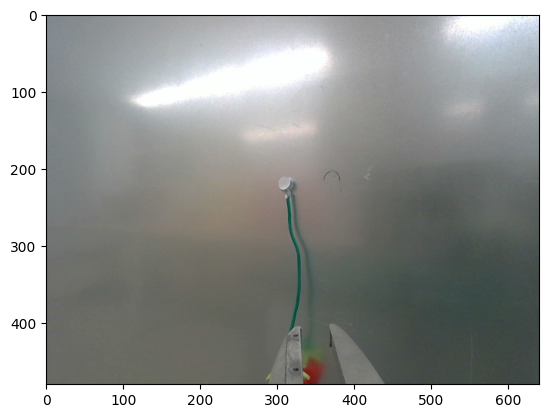

In [77]:
plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

In [78]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)
# print(actual_actions)

In [79]:
actual_action[:4]

array([-0.0973413 , -0.02940133, -1.5057623 ,  1.7307003 ], dtype=float32)

In [80]:
actual_action[4]

0.00038026366

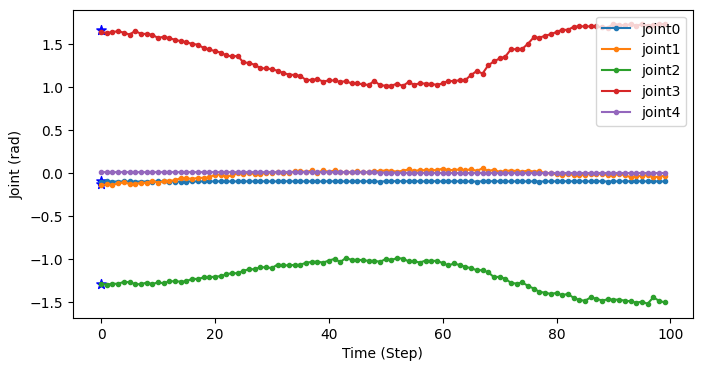

In [81]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


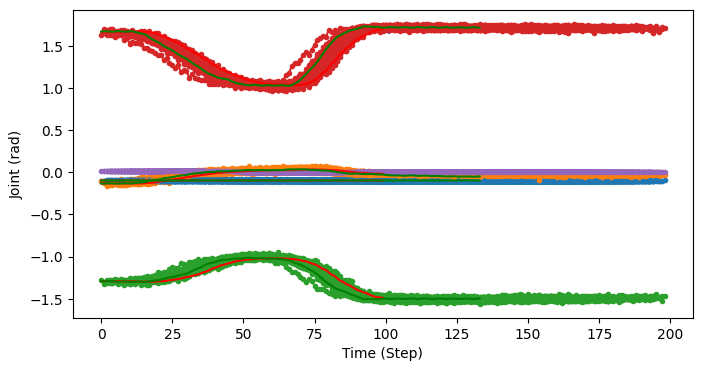

In [109]:
plt.figure(figsize=(8, 4))
qpos_gts = []
all_actual_actions = []
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(100):
            start_step = index 
            qpos_np = root["/observations/qpos"][index]
            qpos_gts.append(qpos_np.copy())
            img_np = root["/observations/images/wrist"][index]
            qpos = pre_process_qpos(qpos_np)
            curr_img = pre_proccess_img(img_np)
            # print("qpos: ",qpos.shape)
            # print("curr_img: ",curr_img.shape)
            all_actions = policy(qpos, curr_img)
            all_actions = all_actions.squeeze(0).cpu().numpy()
            joint_states_traj = []
            actual_actions = []
            steps = np.arange(0, len(all_actions), 1)
            steps = steps + start_step
            for i, raw_action in enumerate(all_actions):
                actual_action = post_process_action(raw_action)
                actual_actions.append(actual_action)
            actual_actions = np.asarray(actual_actions)
            all_actual_actions.append(actual_actions)
            plt.plot(steps, actual_actions[:, 0], marker=".", c="C0", label='joint0')
            plt.plot(steps, actual_actions[:, 1], marker=".", c="C1", label='joint1')
            plt.plot(steps, actual_actions[:, 2], marker=".", c="C2", label='joint2')
            plt.plot(steps, actual_actions[:, 3], marker=".", c="C3", label='joint3')
            plt.plot(steps, actual_actions[:, 4], marker=".", c="C4", label='joint4')
qpos_gts = np.asarray(qpos_gts)
plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.scatter(len(qpos_gts), qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(len(qpos_gts), qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(len(qpos_gts), qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(len(qpos_gts), qpos_np[3], marker="*", c="b", s=50, label='joint3')
plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


plt.plot(action_obs_np[:, 0], c="g",label='joint0')
plt.plot(action_obs_np[:, 1], c="g",label='joint1')
plt.plot(action_obs_np[:, 2], c="g",label='joint2')
plt.plot(action_obs_np[:, 3], c="g",label='joint3')




## KDL Forward Kinematics

In [83]:
actual_actions[0]

array([-0.10020415, -0.13267997, -1.3180294 ,  1.679072  ,  0.01009452],
      dtype=float32)

In [84]:
def joint_states_to_jnt_array(joint_states):
    # Convert joint states to a KDL JntArray
    kdl_joint_array = PyKDL.JntArray(len(joint_states))
    for i, value in enumerate(joint_states):
        kdl_joint_array[i] = value
    kdl_joint_array
    return kdl_joint_array

def get_frame_pose(fk_solver, kdl_joint_array):
    frame = PyKDL.Frame()
    fk_solver.JntToCart(kdl_joint_array, frame)
    # Extract position and orientation
    position = [frame.p.x(), frame.p.y(), frame.p.z()]
    orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                    frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]
    return position, orientation

def joint_states_to_ee_pose(all_joint_states, fk_solver):
    positions = []
    orientations = []
    for i, joint_states in enumerate(all_joint_states):
        kdl_joint_array = joint_states_to_jnt_array(joint_states)
        position, orientation = get_frame_pose(fk_solver, kdl_joint_array)
        positions.append(position)
        orientations.append(orientation)
        
    positions = np.asarray(positions)
    orientations = np.asarray(orientations)
    return positions, orientations

def plot_3d_trajectory(traj, figsize=(8, 6), title="EE Trajectory"):
    """
    Plots a 3D trajectory with enhanced visualization.

    Args:
        traj (list of lists): The 3D trajectory data, where each inner list represents a point (x, y, z).
        figsize (tuple, optional): Figure size in inches. Defaults to (8, 6).
        title (str, optional): Plot title. Defaults to "3D Trajectory".
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory with clear markers and line
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

    # Set labels, title, and initial viewpoint
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ax.set_xlim(-1, +1)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.5)
    ax.set_title(title)
    ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

    # Optional: Add grid and axes limits
    ax.grid(True)
    # Set appropriate limits based on your data range

    plt.show()




In [99]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("body_link", "camera_link")  # Replace with actual link names
fk_solver = PyKDL.ChainFkSolverPos_recursive(chain)


ok:  True


In [188]:
chain = tree.getChain("body_link", "camera_link")  # Replace with actual link names
chain

[base_link:[base_joint:[Fixed, axis: [           0,           0,           0], origin[           0,           0,           0]],
 tip: 
[[           1,           0,           0;
            0,          -1, 3.23109e-15;
            0,-3.23109e-15,          -1]
[ 0.000900511, 7.09655e-05,       0.596]]]
link1:[joint1:[TransAxis, axis: [           0,           0,          -1], origin[           0,           0,      0.1059]],
 tip: 
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[           0,           0,      0.1059]]]
link2:[joint2:[RotAxis, axis: [           0,           0,          -1], origin[     0.13184,           0,       0.057]],
 tip: 
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[     0.13184,           0,       0.057]]]
link3:[joint3:[RotAxis, axis: [           0,           0,          -1], origin[        0.22,  -9.923e-05, 

In [356]:
gt_ee_pose, orientations = joint_states_to_ee_pose(action_obs_np[:, :4], fk_solver)


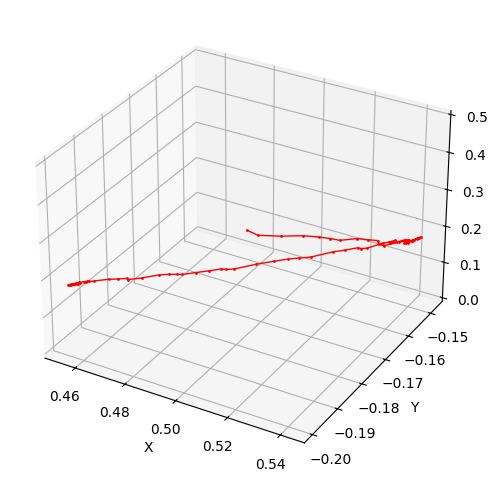

In [121]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')



ax.plot(*zip(*gt_ee_pose[:80]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 0.5)
ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [358]:
util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import tf.transformations as tf_trans


ModuleNotFoundError: No module named 'tf'

In [179]:
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 0.0, 0.0, 429.129150390625, 242.32749938964844, 0.0, 0.0, 0.0, 1.0, 0.0]
]).reshape([3, 4])
rgb_p

array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [341]:
# simulate a line to front
pts_ee = []
for i in range(10):
    pts_ee.append([0.1 * i, 0, 0])
pts_ee = np.asarray(pts_ee)
pts_ee

array([[0. , 0. , 0. ],
       [0.1, 0. , 0. ],
       [0.2, 0. , 0. ],
       [0.3, 0. , 0. ],
       [0.4, 0. , 0. ],
       [0.5, 0. , 0. ],
       [0.6, 0. , 0. ],
       [0.7, 0. , 0. ],
       [0.8, 0. , 0. ],
       [0.9, 0. , 0. ]])

In [355]:
pts_ee = gt_ee_pose.copy()

array([[ 0.45638837, -0.19791185,  0.17931915],
       [ 0.45473074, -0.19912182,  0.17912766],
       [ 0.45566148, -0.19828539,  0.17919149],
       [ 0.45662198, -0.19752947,  0.17931915],
       [ 0.45618982, -0.19803542,  0.17931915],
       [ 0.45526396, -0.19853068,  0.17925532],
       [ 0.45410164, -0.19940128,  0.17912766],
       [ 0.45506497, -0.19865299,  0.17925532],
       [ 0.4557958 , -0.19793828,  0.17931915],
       [ 0.45539414, -0.19852742,  0.17931915],
       [ 0.45443582, -0.19893334,  0.17919149],
       [ 0.45403677, -0.19917577,  0.17912766],
       [ 0.4562562 , -0.19746466,  0.17931915],
       [ 0.45737258, -0.19678893,  0.17931915],
       [ 0.45854771, -0.19593515,  0.17931915],
       [ 0.45819094, -0.19665188,  0.17919149],
       [ 0.45999221, -0.19554137,  0.17912766],
       [ 0.46389796, -0.19350537,  0.17931915],
       [ 0.46634575, -0.19256522,  0.17931915],
       [ 0.46874789, -0.19151782,  0.17931915],
       [ 0.46951572, -0.19176567,  0.179

In [350]:
# camera_T_lidar = np.diag([1, 1, 1, 1])
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0, 0])
pts_camera = camera_T_ee.dot(trans.xyz2homo(pts_ee).T).T[:,: 3]
pts_camera

array([[ 0.12 , -0.008, -0.05 ],
       [ 0.22 , -0.008, -0.05 ],
       [ 0.32 , -0.008, -0.05 ],
       [ 0.42 , -0.008, -0.05 ],
       [ 0.52 , -0.008, -0.05 ],
       [ 0.62 , -0.008, -0.05 ],
       [ 0.72 , -0.008, -0.05 ],
       [ 0.82 , -0.008, -0.05 ],
       [ 0.92 , -0.008, -0.05 ],
       [ 1.02 , -0.008, -0.05 ]])

In [349]:
pts_camera

array([[ 0.   , -0.008, -0.05 ],
       [ 0.12 , -0.008, -0.05 ],
       [ 0.24 , -0.008, -0.05 ],
       [ 0.36 , -0.008, -0.05 ],
       [ 0.48 , -0.008, -0.05 ],
       [ 0.6  , -0.008, -0.05 ],
       [ 0.72 , -0.008, -0.05 ],
       [ 0.84 , -0.008, -0.05 ],
       [ 0.96 , -0.008, -0.05 ],
       [ 1.08 , -0.008, -0.05 ]])

In [352]:
pts_in_camera_opt = pts_camera.copy()
pts_in_camera_opt = pts_in_camera_opt[:, [1, 2, 0]]
pts_in_camera_opt[:, 2] = pts_in_camera_opt[:, 2]
pts_in_camera_opt[:, 0] = -pts_in_camera_opt[:, 0]
pts_in_camera_opt[:, 1] = -pts_in_camera_opt[:, 1]


In [353]:
# uv = project_points_to_uv_batch(rgb_p, pts_optical)
uvs = proj.project_point_to_image(pts_in_camera_opt, rgb_p)


/home/zfei/code/act-plus-plus/playground/utils/projections.py:29: RuntimeWarning: divide by zero encountered in divide
  point_on_image = (projection_matrix.dot(pt_homo)/pt_homo[2, :]).T[:, :2]
/home/zfei/code/act-plus-plus/playground/utils/projections.py:29: RuntimeWarning: invalid value encountered in divide
  point_on_image = (projection_matrix.dot(pt_homo)/pt_homo[2, :]).T[:, :2]


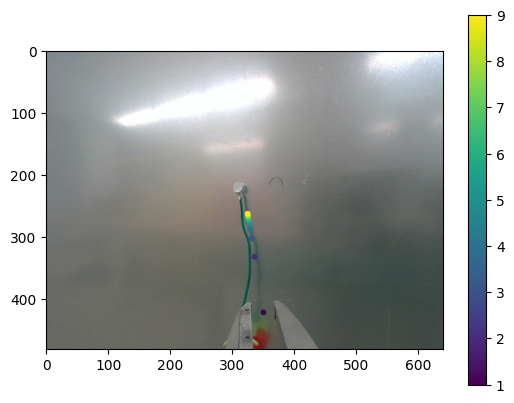

In [354]:
img_plot = img_np.copy()

plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
plt.colorbar()